In [2]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler

In [3]:
# read in dataset
df = pd.read_csv("/Users/xander/Desktop/DATA1030project/data/savant_data_clayton_kershaw.csv")
print(df.shape)

(13008, 94)


In [4]:
# EDA part
# select columns that are used to predict the release_speed based on pitch_type
n_df = df[["pitch_type", "release_speed", "release_pos_x", "release_pos_y", 
           "release_pos_z",'balls','strikes','outs_when_up',"stand", "p_throws", 
           "ax", "ay", "az",'release_extension']]

n_df = n_df[n_df['pitch_type'] != 'FS']
n_df = n_df[n_df['pitch_type'] != 'SI']


# replace the null/NaN/?/none with NaN/Unknown
n_df = n_df.replace('?', np.nan)

n_df['pitch_type'] = n_df['pitch_type'].fillna('Unknown')

# check the shape of data frame
print(n_df.shape)

# check the types of each feature
print(n_df.dtypes)
print(n_df.head())


(12957, 14)
pitch_type            object
release_speed        float64
release_pos_x        float64
release_pos_y        float64
release_pos_z        float64
balls                  int64
strikes                int64
outs_when_up           int64
stand                 object
p_throws              object
ax                   float64
ay                   float64
az                   float64
release_extension    float64
dtype: object
  pitch_type  release_speed  release_pos_x  release_pos_y  release_pos_z  \
1         FF           89.2           1.76          54.08           6.24   
2         SL           86.3           1.67          54.06           6.23   
3         CU           73.1           1.40          53.82           6.46   
4         SL           87.1           1.71          53.95           6.19   
5         FF           89.9           1.70          54.03           6.21   

   balls  strikes  outs_when_up stand p_throws        ax         ay  \
1      0        1             1     R   

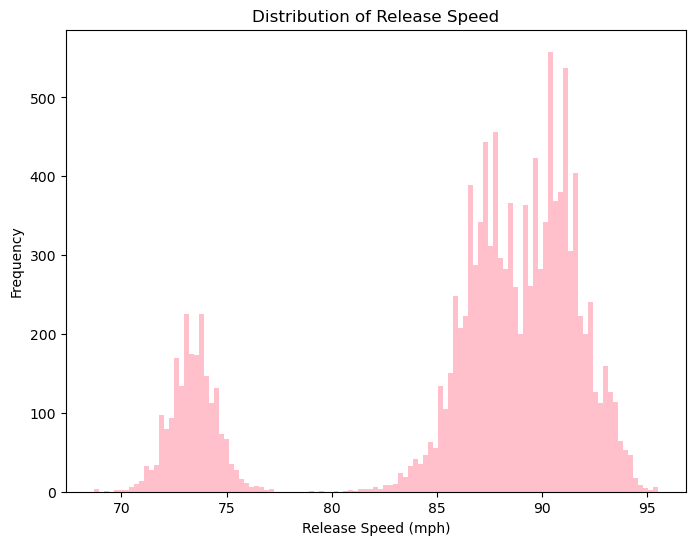

In [5]:
# distribution of target variable
plt.figure(figsize=(8,6))
plt.hist(n_df['release_speed'],bins = int(np.sqrt(n_df.shape[0])), color='pink')
plt.title('Distribution of Release Speed')
plt.xlabel('Release Speed (mph)')
plt.ylabel('Frequency')
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/target_variable_distribution.png',dpi=300,bbox_inches="tight")
plt.show()


  pitch_type  percentage
0         FF   41.429343
1         SL   41.151501
2         CU   16.601065
3         CH    0.818091


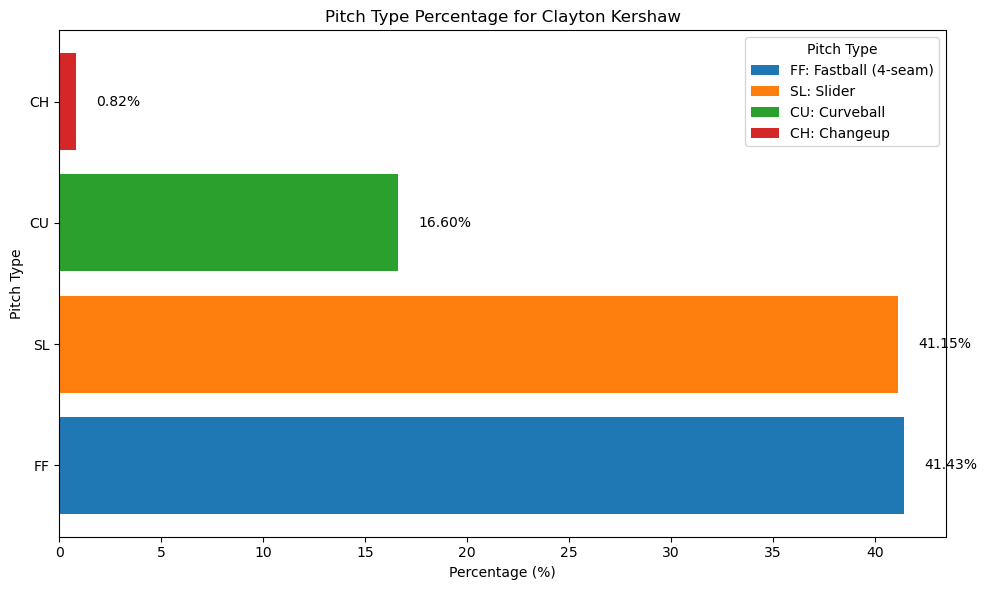

In [6]:
# compute the percentage of each pitch type among the total number of pitchs during 2017-2023 exclusive 2020
pitch_type_counts = n_df['pitch_type'].value_counts(normalize=True) * 100

pitch_type_percentages = pd.DataFrame({
    'pitch_type': pitch_type_counts.index,
    'percentage': pitch_type_counts.values
})

print(pitch_type_percentages)

plt.figure(figsize=(10, 6))

for i, row in pitch_type_percentages.iterrows():
    plt.barh(row['pitch_type'], row['percentage'], label=row['pitch_type'])
    plt.text(row['percentage'] + 1, i, f"{row['percentage']:.2f}%", va='center')


plt.title('Pitch Type Percentage for Clayton Kershaw')
plt.xlabel('Percentage (%)')
plt.ylabel('Pitch Type')

# full name of each pitch type
pitch_type = {
    'FF': 'Fastball (4-seam)',
    'SL': 'Slider',
    'CU': 'Curveball',
    'CH': 'Changeup',
    'SI': 'Sinker (2-Seam)',
    'FS': 'Split-finger',
    'FA': 'Other'
}
plt.legend([f'{key}: {value}' for key, value in pitch_type.items()], title='Pitch Type', loc='upper right', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/pitch_type_distribution.png',dpi=300,bbox_inches="tight")
plt.show()

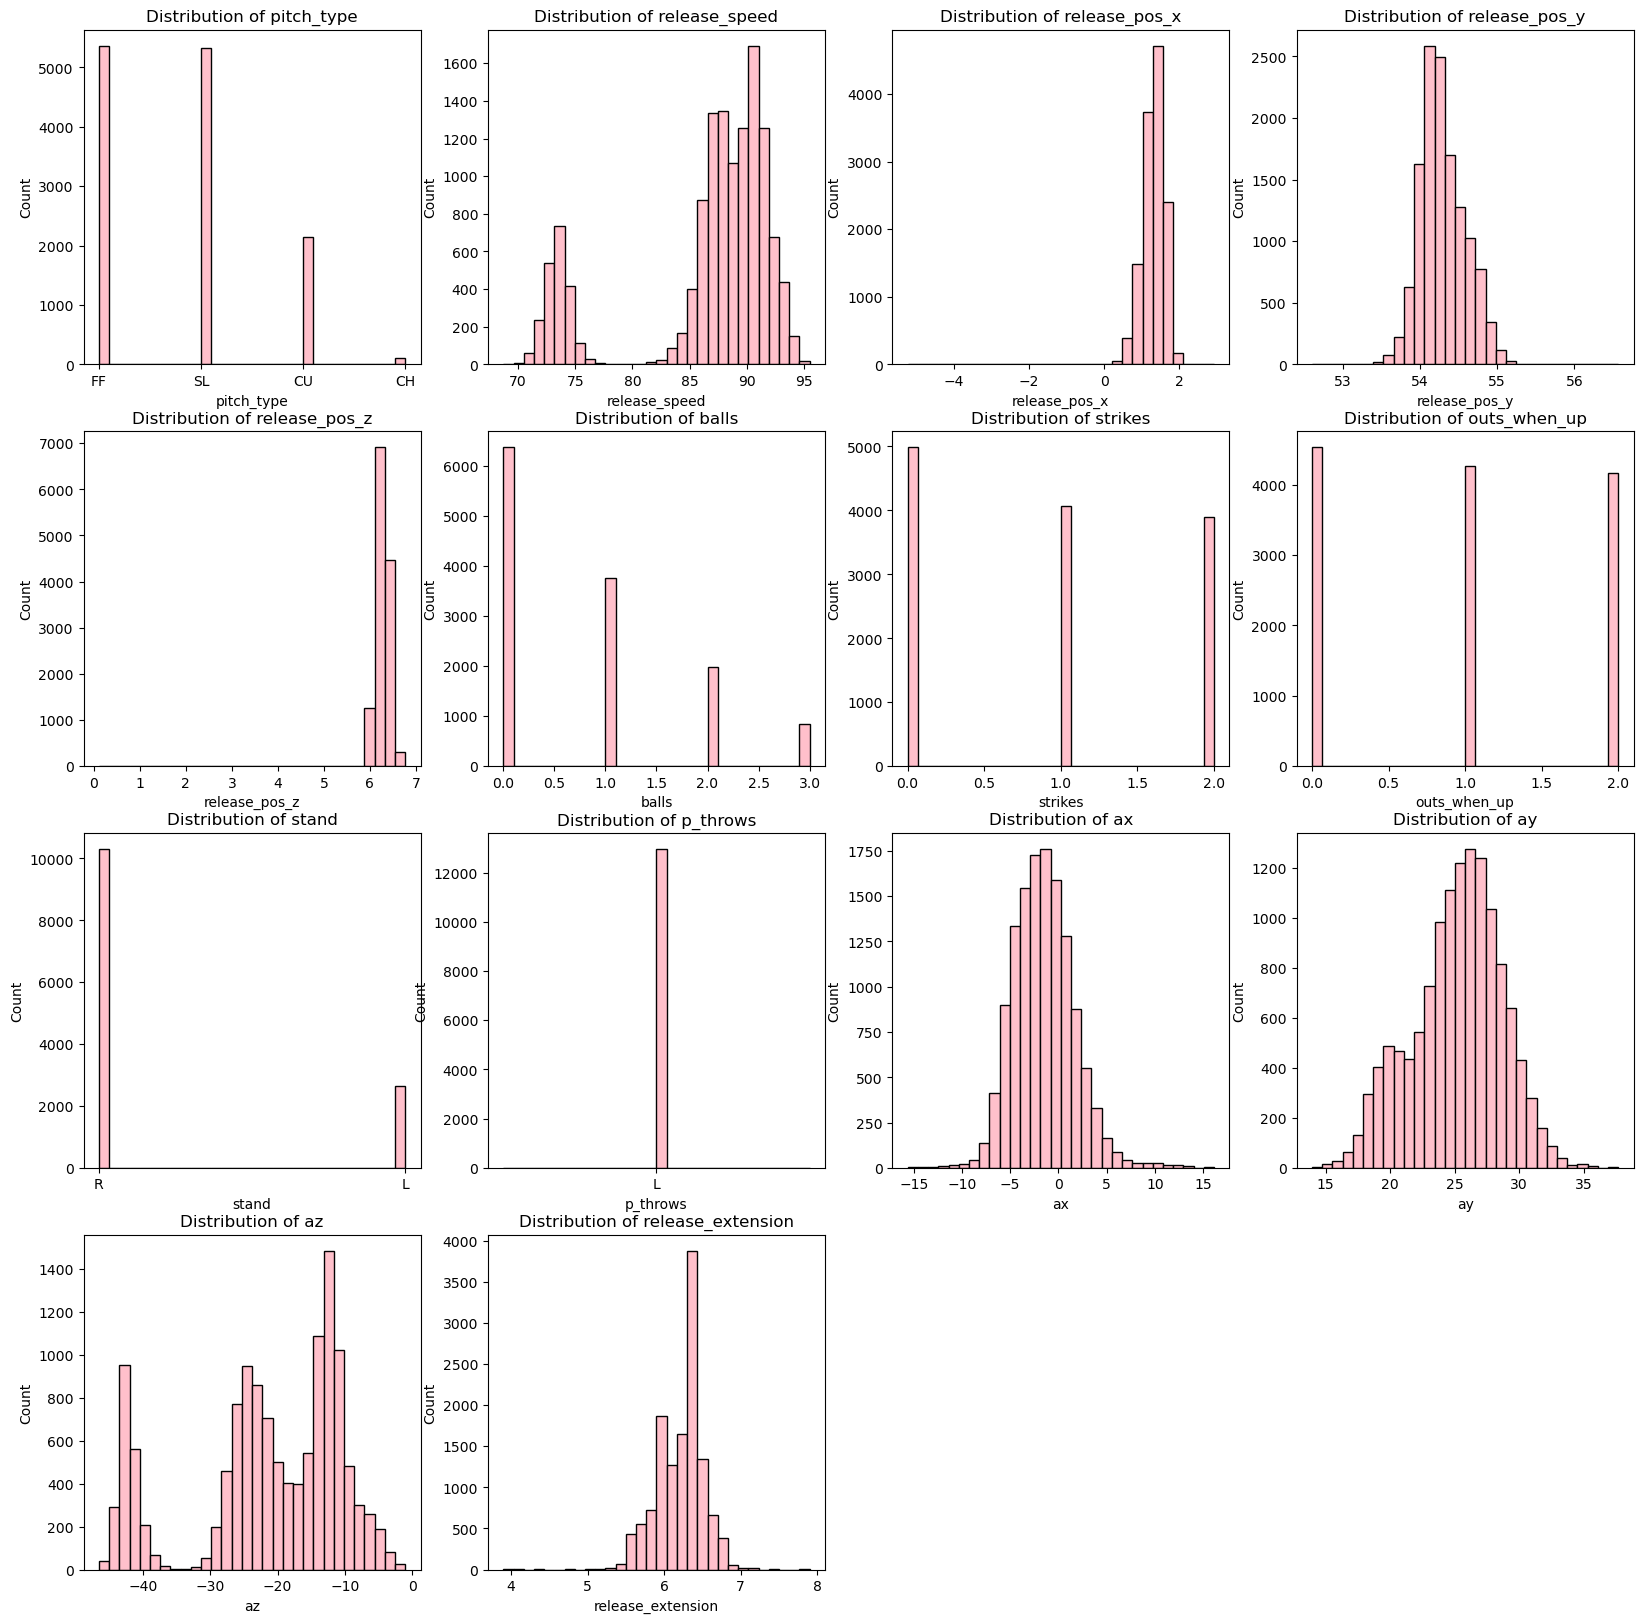

In [7]:
only_features = df[["pitch_type", "release_speed", "release_pos_x", "release_pos_y", 
           "release_pos_z",'balls','strikes','outs_when_up',"stand", "p_throws", 
           "ax", "ay", "az",'release_extension']]

plt.figure(figsize=(20, 20))

for i, feature in enumerate(only_features):
    plt.subplot(4, 4, i+1)
    plt.hist(n_df[feature], bins=30, color='pink', edgecolor='black')
    plt.title(f'Distribution of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/feature_distributions.png',dpi=300,bbox_inches="tight")
plt.show()

<Figure size 600x600 with 0 Axes>

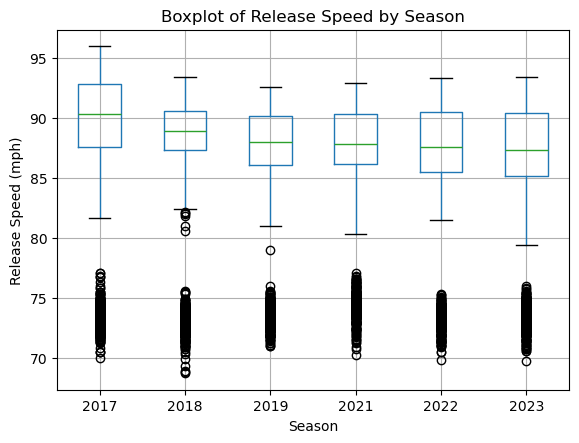

In [8]:
df['game_date'] = pd.to_datetime(df['game_date'])

df['season'] = df['game_date'].dt.year

plt.figure(figsize=(6, 6))
df.boxplot(column='release_speed', by='season')
plt.title('Boxplot of Release Speed by Season')
plt.suptitle('')
plt.xlabel('Season')
plt.ylabel('Release Speed (mph)')
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/release_speed_box_plot.png',dpi=300,bbox_inches="tight")
plt.show()

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, GroupShuffleSplit
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

y = n_df['release_speed']
pitch_type = n_df['pitch_type']
X = n_df.drop(columns=['release_speed'])

def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
   
    test_scores = []
    best_models = []
    result = []
    X_tests = []
    y_tests = []
    grid_searches = []
    
    for random_state in range(5):
        
        splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
        for i_other, i_test in splitter.split(X, y, groups=pitch_type):
            X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], pitch_type.iloc[i_other]
            X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], pitch_type.iloc[i_test]
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', ML_algo)])
       
        cv = GroupKFold(n_splits=3)
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv.split(X_other, y_other,groups_other), 
                                   scoring='neg_root_mean_squared_error')
        

        grid_search.fit(X_other, y_other)

        best_model = grid_search.best_estimator_
        y_test_pred = best_model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        
        results = pd.DataFrame(grid_search.cv_results_)
        test_scores.append(rmse)
        best_models.append(best_model)
        result.append(results)
        X_tests.append(X_test)
        y_tests.append(y_test)
        grid_searches.append(grid_search)

        print(f"Random state: {random_state}: RMSE: {rmse}")

    return grid_searches, test_scores, best_models, result,  X_tests, y_tests

preprocessor:

In [10]:
onehot_ftrs = ['pitch_type', 'stand', 'p_throws']
std_ftrs = ["release_pos_x", "release_pos_y", 
           "release_pos_z", "ax", "ay", "az",'balls','strikes','release_extension']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

Baseline:

In [11]:
# baseline 

baseline_pred = np.mean(y)

baseline_rmse = np.sqrt(mean_squared_error(y, np.full_like(y, baseline_pred)))
baseline_std = np.std(baseline_rmse)

print(f"Baseline RMSE: {baseline_rmse}")
print(f"Baseline STD: {baseline_std}")



Baseline RMSE: 6.272638112030184
Baseline STD: 0.0


linear regression l1 lasso regularization:

In [12]:
from sklearn.linear_model import Lasso
ML_algo_lasso = Lasso(max_iter=1000000)
param_grid_lasso = {'model__alpha': np.logspace(-7, 0, 29)}

grid_searches, test_scores, best_models, result, X_tests, y_tests = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo_lasso, param_grid_lasso)

lasso_mean_rmse = np.mean(test_scores)
lasso_std = np.std(test_scores)
print("Test Scores:", test_scores)
print("Mean RMSE:", lasso_mean_rmse)
print("Standard Deviation of RMSE:", lasso_std)

Random state: 0: RMSE: 3.555405304870389
Random state: 1: RMSE: 4.379090784786075
Random state: 2: RMSE: 3.555405304870389
Random state: 3: RMSE: 4.379090784786075
Random state: 4: RMSE: 3.87542659937832
Test Scores: [3.555405304870389, 4.379090784786075, 3.555405304870389, 4.379090784786075, 3.87542659937832]
Mean RMSE: 3.9488837557382497
Standard Deviation of RMSE: 0.370189873470235


linear regression l2 Ridge regularization:

In [13]:
from  sklearn.linear_model import Ridge
ML_algo_ridge = Ridge()
param_grid_ridge = {'model__alpha': np.logspace(-10,0,51)}

grid_searches, test_scores, best_models, result, X_tests, y_tests = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo_ridge, param_grid_ridge)

ridge_mean_rmse = np.mean(test_scores)
ridge_std = np.std(test_scores)
print("Test Scores:", test_scores)
print("Mean RMSE:", ridge_mean_rmse)
print("Standard Deviation of RMSE:", ridge_std)

Random state: 0: RMSE: 4.77037282479959
Random state: 1: RMSE: 4.089495564907239
Random state: 2: RMSE: 4.77037282479959
Random state: 3: RMSE: 4.089495564907239
Random state: 4: RMSE: 1.4345882065461328
Test Scores: [4.77037282479959, 4.089495564907239, 4.77037282479959, 4.089495564907239, 1.4345882065461328]
Mean RMSE: 3.830864997191958
Standard Deviation of RMSE: 1.2362258624356097


linear regression elastic net:

In [19]:
from sklearn.linear_model import ElasticNet
ML_algo_en = ElasticNet(max_iter=10000)

param_grid_en = {
    'model__alpha': np.logspace(-3, 1, 10),
    'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 1.0]
}

grid_searches, test_scores, best_models, result, X_tests, y_tests = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo_en, param_grid_en)

en_mean_rmse = np.mean(test_scores)
en_std = np.std(test_scores)
print("Test Scores:", test_scores)
print("Mean RMSE:", en_mean_rmse)
print("Standard Deviation of RMSE:", en_std)

Random state: 0: RMSE: 3.8181132340965207
Random state: 1: RMSE: 3.9291732496430214
Random state: 2: RMSE: 3.8181132340965207
Random state: 3: RMSE: 3.9291732496430214
Random state: 4: RMSE: 3.825209223445714
Test Scores: [3.8181132340965207, 3.9291732496430214, 3.8181132340965207, 3.9291732496430214, 3.825209223445714]
Mean RMSE: 3.8639564381849594
Standard Deviation of RMSE: 0.0533123069576819


random forest regression:

In [20]:
from sklearn.ensemble import RandomForestRegressor
ML_algo_rf = RandomForestRegressor()
param_grid_rf = {
    'model__max_depth': [1, 2, 3, 10, 30],
    'model__max_features': ['sqrt', 'log2']
}

grid_searches, test_scores, best_models, result, X_tests, y_tests = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo_rf, param_grid_rf)

rf_mean_rmse = np.mean(test_scores)
rf_std = np.std(test_scores)
print("Test Scores:", test_scores)
print("Mean RMSE:", rf_mean_rmse)
print("Standard Deviation of RMSE:", rf_std)

Random state: 0: RMSE: 5.564151385807888
Random state: 1: RMSE: 2.1027796359649544
Random state: 2: RMSE: 5.13218508273797
Random state: 3: RMSE: 3.1739300841542413
Random state: 4: RMSE: 2.1369330927239467
Test Scores: [5.564151385807888, 2.1027796359649544, 5.13218508273797, 3.1739300841542413, 2.1369330927239467]
Mean RMSE: 3.6219958562778003
Standard Deviation of RMSE: 1.4674353050479056


SVR:

In [22]:
from sklearn.svm import SVR

ML_algo_svr = SVR()
param_grid_svr = {
    'model__gamma': [1e-3, 1e-1, 1e1, 1e3],
    'model__C': [1e-2, 1e-1, 1e0, 1e1]
}

grid_searches, test_scores, best_models, result, X_tests, y_tests = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo_svr, param_grid_svr)

svr_mean_rmse = np.mean(test_scores)
svr_std = np.std(test_scores)
print("Test Scores:", test_scores)
print("Mean RMSE:", svr_mean_rmse)
print("Standard Deviation of RMSE:", svr_std)

Random state: 0: RMSE: 3.863177767821823
Random state: 1: RMSE: 3.796928749468097
Random state: 2: RMSE: 3.863177767821823
Random state: 3: RMSE: 3.796928749468097
Random state: 4: RMSE: 2.1265882836922634
Test Scores: [3.863177767821823, 3.796928749468097, 3.863177767821823, 3.796928749468097, 2.1265882836922634]
Mean RMSE: 3.489360263654421
Standard Deviation of RMSE: 0.6820298042087758


XGBoost:

In [36]:
import xgboost

ML_algo_xgb = xgboost.XGBRegressor(n_jobs=1)

param_grid_xgb = {"model__learning_rate": [0.03],
                  "model__n_estimators": [100],
                  "model__seed": [0],
                  "model__reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "model__reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "model__max_depth": [1,3,10,30,100],
                  "model__colsample_bytree": [0.9],              
                  "model__subsample": [0.66]}


grid_searches, test_scores, best_models, result, X_tests, y_tests = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo_xgb, param_grid_xgb)

xgb_mean_rmse = np.mean(test_scores)
xgb_std = np.std(test_scores)
print("Test Scores:", test_scores)
print("Mean RMSE:", xgb_mean_rmse)
print("Standard Deviation of RMSE:", xgb_std)

Random state: 0: RMSE: 3.8088843774381345
Random state: 1: RMSE: 1.469186355138599
Random state: 2: RMSE: 3.8088843774381345
Random state: 3: RMSE: 1.469186355138599
Random state: 4: RMSE: 2.446175479857256
Test Scores: [3.8088843774381345, 1.469186355138599, 3.8088843774381345, 1.469186355138599, 2.446175479857256]
Mean RMSE: 2.6004633890021447
Standard Deviation of RMSE: 1.049184710543166


Test Scores of Algorithms plot:

[3.9488837557382497, 3.830864997191958, 3.8639564381849594, 3.6219958562778003, 3.489360263654421, 2.6004633890021447, 6.272638112030184]


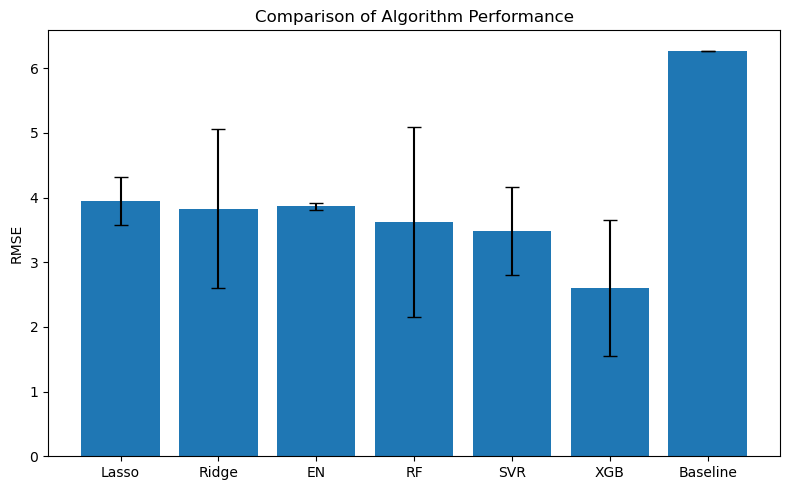

In [59]:
import matplotlib.pyplot as plt

algorithms = ['Lasso', 'Ridge', 'EN','RF','SVR', 'XGB', 'Baseline']
rmse_means = [lasso_mean_rmse, ridge_mean_rmse, en_mean_rmse, rf_mean_rmse, svr_mean_rmse, xgb_mean_rmse, baseline_rmse]
rmse_stds = [lasso_std, ridge_std, en_std, rf_std, svr_std, xgb_std, baseline_std]
print(rmse_means)
plt.figure(figsize=(8, 5))
plt.bar(algorithms, rmse_means, yerr=rmse_stds, capsize=5)
plt.ylabel('RMSE')
plt.title('Comparison of Algorithm Performance')
plt.tight_layout()
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/model_comparsion.png',dpi=300,bbox_inches="tight")
plt.show()


In [38]:
min_rmse_mean_index = np.argmin(rmse_means)

min_rmse_mean_model = algorithms[min_rmse_mean_index]
print(min_rmse_mean_model)

XGB


Thus, we rerun XGBoost below:

In [61]:
import xgboost

ML_algo_xgb = xgboost.XGBRegressor(n_jobs=1)

param_grid_xgb = {"model__learning_rate": [0.03],
                  "model__n_estimators": [100],
                  "model__seed": [0],
                  "model__reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "model__reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "model__max_depth": [1,3,10,30,100],
                  "model__colsample_bytree": [0.9],              
                  "model__subsample": [0.66]}


grid_searches, test_scores, best_models, result, X_tests, y_tests = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo_xgb, param_grid_xgb)

xgb_mean_rmse = np.mean(test_scores)
xgb_std = np.std(test_scores)
print("Test Scores:", test_scores)
print("Mean RMSE:", xgb_mean_rmse)
print("Standard Deviation of RMSE:", xgb_std)

Random state: 0: RMSE: 3.8088843774381345
Random state: 1: RMSE: 1.469186355138599
Random state: 2: RMSE: 3.8088843774381345
Random state: 3: RMSE: 1.469186355138599
Random state: 4: RMSE: 2.446175479857256
Test Scores: [3.8088843774381345, 1.469186355138599, 3.8088843774381345, 1.469186355138599, 2.446175479857256]
Mean RMSE: 2.6004633890021447
Standard Deviation of RMSE: 1.049184710543166


In [73]:

best_rmse_index = np.argmin(test_scores)

best_rmse = test_scores[best_rmse_index]
best_random_state = best_rmse_index 

best_model = best_models[best_rmse_index]
X_test = X_tests[best_rmse_index]
y_test = y_tests[best_rmse_index]
grid_search = grid_searches[best_rmse_index]
feature_names = grid_search.best_estimator_[0].get_feature_names_out()

print(f"Best Random State: {best_random_state}")
print(f"Best RMSE: {best_rmse}")
print(f"Best Model: {best_model}")
print(f"Best Model Parameters: {grid_search.best_params_}")
print(feature_names)

Best Random State: 1
Best RMSE: 1.469186355138599
Best Model: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['pitch_type', 'stand',
                                                   'p_throws']),
                                                 ('std', StandardScaler(),
                                                  ['release_pos_x',
                                                   'release_pos_y',
                                                   'release_pos_z', 'ax', 'ay',
                                                   'az', 'balls', 'strikes',
                                                   'release_extension'])])),
                ('model',
                 XGBRegressor(base_score=None, booster=None,

In [74]:
import pickle
pickle.dump(best_model, open('/Users/xander/Desktop/DATA1030project/results/model.pkl','wb'))

In [75]:
y_pred = best_model[1].predict(best_model[0].transform(X_test))
prediction = pd.DataFrame(y_pred, columns=['predictions']).to_csv('/Users/xander/Desktop/DATA1030project/results/prediction.csv')

Permutation importance:

Feature Importance Scores:
onehot__pitch_type_CH: 0.0000
onehot__pitch_type_CU: 0.0000
onehot__pitch_type_FF: 0.0000
onehot__stand_L: -0.0003
onehot__stand_R: -0.0001
onehot__p_throws_L: 0.0000
std__release_pos_x: 0.1476
std__release_pos_y: -0.0079
std__release_pos_z: -0.0326
std__ax: -0.0044
std__ay: 0.0751
std__az: 0.0262
std__balls: 0.0000
std__strikes: 0.0008
std__release_extension: 0.0000


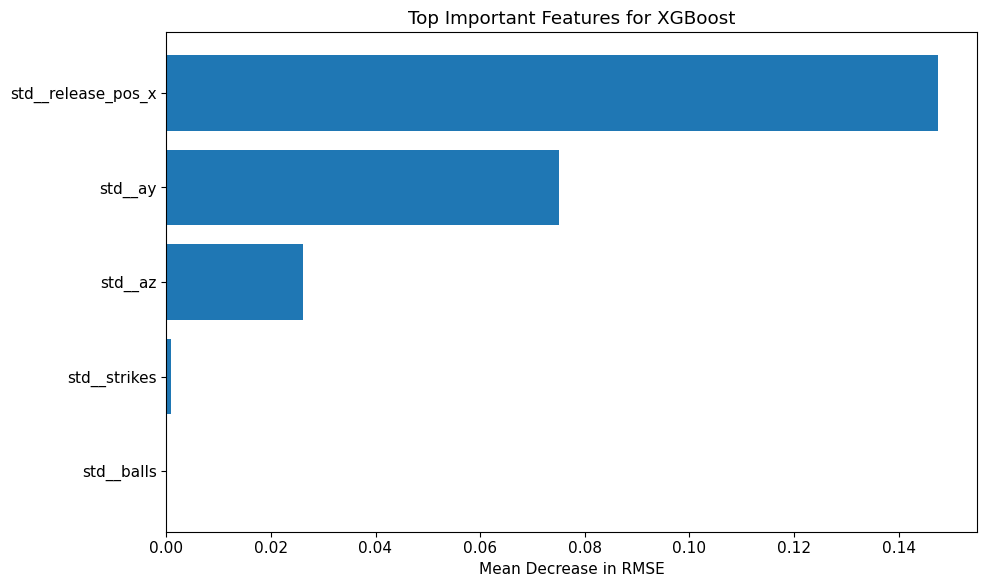

In [92]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

X_test_transformed = best_model[0].transform(X_test)

column_names = feature_names

result = permutation_importance(
    best_model[1], 
    X_test_transformed, 
    y_test,
    n_repeats=10,
    random_state=42
)

importance_mean_score = result.importances_mean
sorted_indices = np.argsort(importance_mean_score)[::-1]
top_features = sorted_indices[:5] 

top_importances = importance_mean_score[top_features]
top_feature_names = [column_names[i] for i in top_features]
print("Feature Importance Scores:")
for i, score in enumerate(importance_mean_score):
    print(f"{column_names[i]}: {score:.4f}")
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names[::-1], top_importances[::-1])
plt.xlabel('Mean Decrease in RMSE')
plt.title('Top Important Features for XGBoost')
plt.tight_layout()
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/permutation_importance.png',dpi=300,bbox_inches="tight")
plt.show()


In [89]:
import pickle

np.random.seed(42)

nr_runs = 10
scores = np.zeros([len(ftr_names),nr_runs])

test_score = grid_search.score(X_test,y_test)
ftr_names = X.columns
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = X_test.copy()
        X_test_shuffled[ftr_names[i]] = np.random.permutation(X_test[ftr_names[i]].values)
        acc_scores.append(grid_search.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

shuffling pitch_type
   shuffled test score: -1.469 +/- 0.0
shuffling release_pos_x
   shuffled test score: -1.575 +/- 0.003
shuffling release_pos_y
   shuffled test score: -1.463 +/- 0.0
shuffling release_pos_z
   shuffled test score: -1.444 +/- 0.001
shuffling balls
   shuffled test score: -1.469 +/- 0.0
shuffling strikes
   shuffled test score: -1.47 +/- 0.0
shuffling outs_when_up
   shuffled test score: -1.469 +/- 0.0
shuffling stand
   shuffled test score: -1.469 +/- 0.0
shuffling p_throws
   shuffled test score: -1.469 +/- 0.0
shuffling ax
   shuffled test score: -1.466 +/- 0.0
shuffling ay
   shuffled test score: -1.522 +/- 0.002
shuffling az
   shuffled test score: -1.488 +/- 0.001
shuffling release_extension
   shuffled test score: -1.469 +/- 0.0


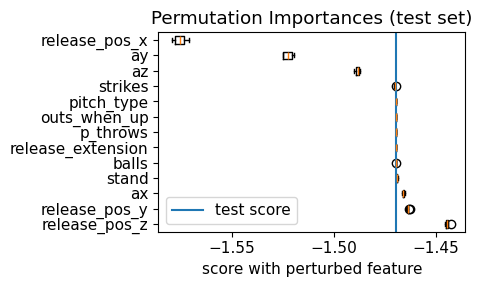

In [91]:
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(5,3))
plt.boxplot(scores[sorted_indcs].T,tick_labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/permutation_importance_2.png',dpi=300,bbox_inches="tight")
plt.show()

SHAP values for global feature importance:

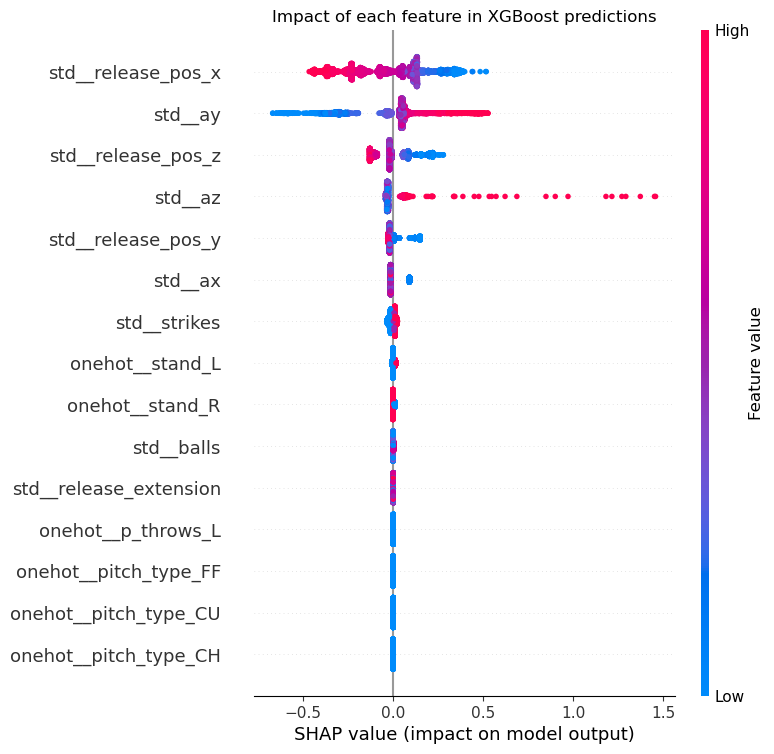

In [63]:
import shap
shap.initjs()

explainer = shap.Explainer(best_model.named_steps['model'], X_test_transformed)
shap_values = explainer.shap_values(X_test_transformed)
shap.summary_plot(
    shap_values, 
    X_test_transformed, 
    feature_names=feature_names,
    show=False
)
fig = plt.gcf()
ax = plt.gca()
ax.set_title("Impact of each feature in XGBoost predictions")
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/global_shap_importance.png',dpi=300,bbox_inches="tight")
plt.show()

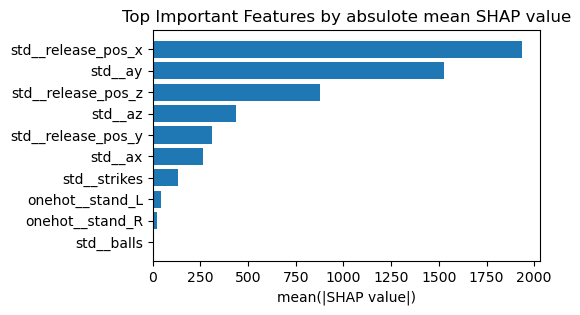

In [55]:
shap_summary = np.sum(np.abs(shap_values),axis=0)+np.sum(np.abs(shap_values),axis=0)
indcs = np.argsort(shap_summary)
shap_summary[indcs]

plt.figure(figsize=(5,3))
plt.barh(feature_names[indcs[-10:]],shap_summary[indcs[-10:]])
plt.xlabel('mean(|SHAP value|)')
plt.title("Top Important Features by absulote mean SHAP value")
plt.savefig('/Users/xander/Desktop/DATA1030project/figures/.png',dpi=300,bbox_inches="tight")
plt.show()

In [64]:

shap.initjs()
index = 0

shap.force_plot(
    explainer.expected_value, 
    shap_values[index, :], 
    features=X_test_transformed[index, :],
    feature_names=feature_names,
    show=False,
    matplotlib=True
).savefig('/Users/xander/Desktop/DATA1030project/figures/local_index_0.png',dpi=300,bbox_inches="tight")

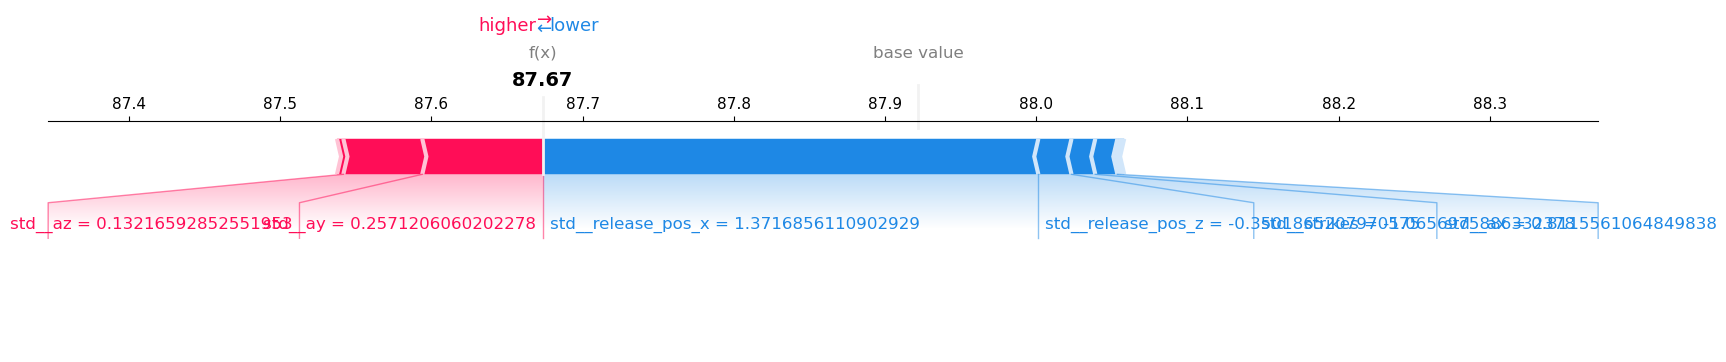

In [93]:
shap.initjs()
index = 0

shap.force_plot(
    explainer.expected_value, 
    shap_values[index, :], 
    features=X_test_transformed[index, :],
    feature_names=feature_names,
    show=False,
    matplotlib=True
)

In [65]:

shap.initjs()
index = 50

shap.force_plot(
    explainer.expected_value, 
    shap_values[index, :], 
    features=X_test_transformed[index, :],
    feature_names=feature_names,
    show=False,
    matplotlib=True
).savefig('/Users/xander/Desktop/DATA1030project/figures/local_index_50.png',dpi=300,bbox_inches="tight")

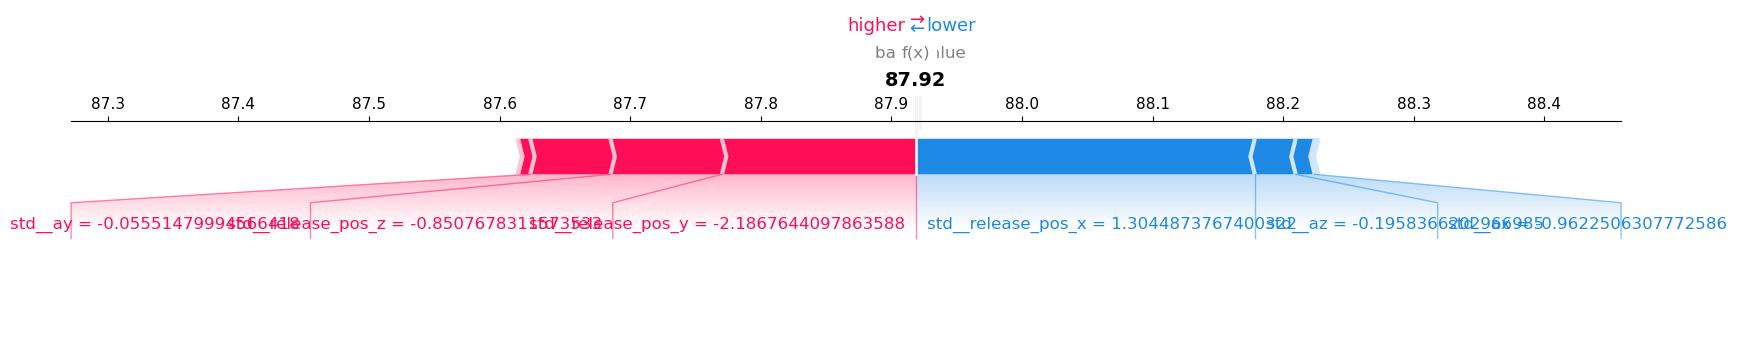

In [94]:
shap.initjs()
index = 50

shap.force_plot(
    explainer.expected_value, 
    shap_values[index, :], 
    features=X_test_transformed[index, :],
    feature_names=feature_names,
    show=False,
    matplotlib=True
)